# Navigation

---
### Project:

This notebook is part of the the first project of the Udacity's [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

In this notebook an agent is trained to navigate through a square world and collect bananas. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:

- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The task is episodic, and in order to solve the environment, the agent must get an average score of +13 over 100 consecutive episodes.

In [1]:
# imports
import random
import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# start environment
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe", no_graphics=True)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 



Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here, it is checked for the first brain available, and it is set as the default brain that will be controlled from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
def training(agent, n_episodes=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    average = []                       # list containing the average scores over the last 100 episodes
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]    
        score = 0
        while True:
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action.astype(int))[brain_name]    # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]  
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        average.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average[i_episode-1]))
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average[i_episode-1]))
            torch.save(agent.primary_network.state_dict(), 'weights\checkpoint_'+str(i_episode)+'.pth')
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, average[i_episode-1]))
            torch.save(agent.primary_network.state_dict(), 'weights\checkpoint_final.pth')
            break
    goal = np.ones(i_episode)*13
    return scores, average, goal

## Training agent with Deep Q Network

In [5]:
from dqn_agent import Agent as Agent_DQN
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

agent_dqn = Agent_DQN(state_size=len(state), action_size=brain.vector_action_space_size, seed=0)

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.00
Episode 3	Average Score: -0.33
Episode 4	Average Score: -0.50
Episode 5	Average Score: -0.60
Episode 6	Average Score: -0.83
Episode 7	Average Score: -0.57
Episode 8	Average Score: -0.50
Episode 9	Average Score: -0.44
Episode 10	Average Score: -0.30
Episode 11	Average Score: -0.45
Episode 12	Average Score: -0.42
Episode 13	Average Score: -0.38
Episode 14	Average Score: -0.36
Episode 15	Average Score: -0.40
Episode 16	Average Score: -0.25
Episode 17	Average Score: -0.24
Episode 18	Average Score: -0.17
Episode 19	Average Score: 0.00
Episode 20	Average Score: 0.10
Episode 21	Average Score: 0.19
Episode 22	Average Score: 0.18
Episode 23	Average Score: 0.17
Episode 24	Average Score: 0.21
Episode 25	Average Score: 0.16
Episode 26	Average Score: 0.15
Episode 27	Average Score: 0.15
Episode 28	Average Score: 0.18
Episode 29	Average Score: 0.24
Episode 30	Average Score: 0.23
Episode 31	Average Score: 0.19
Episode 32	Average Score: 0.22
E

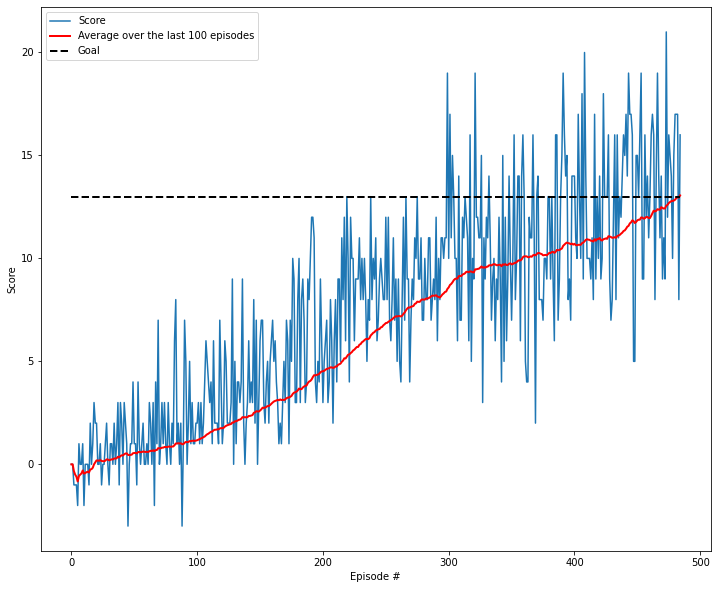

In [ ]:
scores, average, goal = training(agent_dqn)

# plot the scores
fig = plt.figure(figsize=(12, 10))
plt.plot(np.arange(len(scores)), scores, label = 'Score')
plt.plot(average, 'r-', label = 'Average over the last 100 episodes',linewidth = 2)
plt.plot(goal, 'k--',label = 'Goal', linewidth = 2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### Load pretrained weights

In [ ]:
agent_dqn.primary_network.load_state_dict(torch.load('dqn_results\weights\checkpoint_final.pth'))

In [ ]:
while True:
    state = env_info.vector_observations[0]
    with torch.no_grad():
        action = agent_dqn.primary_network(state)
    env_info = env.step(action.astype(int))[brain_name] 
    done = env_info.local_done[0]
    if done:
        break

## Training agent with Double Deep Q Network

In [5]:
from ddqn_agent import Agent as Agent_DDQN
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

agent_ddqn = Agent_DDQN(state_size=len(state), action_size=brain.vector_action_space_size, seed=0)

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.00
Episode 3	Average Score: 0.00
Episode 4	Average Score: 0.00
Episode 5	Average Score: 0.20
Episode 6	Average Score: 0.17
Episode 7	Average Score: 0.14
Episode 8	Average Score: 0.25
Episode 9	Average Score: 0.22
Episode 10	Average Score: 0.40
Episode 11	Average Score: 0.45
Episode 12	Average Score: 0.50
Episode 13	Average Score: 0.46
Episode 14	Average Score: 0.43
Episode 15	Average Score: 0.40
Episode 16	Average Score: 0.44
Episode 17	Average Score: 0.41
Episode 18	Average Score: 0.33
Episode 19	Average Score: 0.26
Episode 20	Average Score: 0.25
Episode 21	Average Score: 0.38
Episode 22	Average Score: 0.41
Episode 23	Average Score: 0.43
Episode 24	Average Score: 0.38
Episode 25	Average Score: 0.40
Episode 26	Average Score: 0.38
Episode 27	Average Score: 0.37
Episode 28	Average Score: 0.50
Episode 29	Average Score: 0.52
Episode 30	Average Score: 0.40
Episode 31	Average Score: 0.39
Episode 32	Average Score: 0.38
Episode 33	Averag

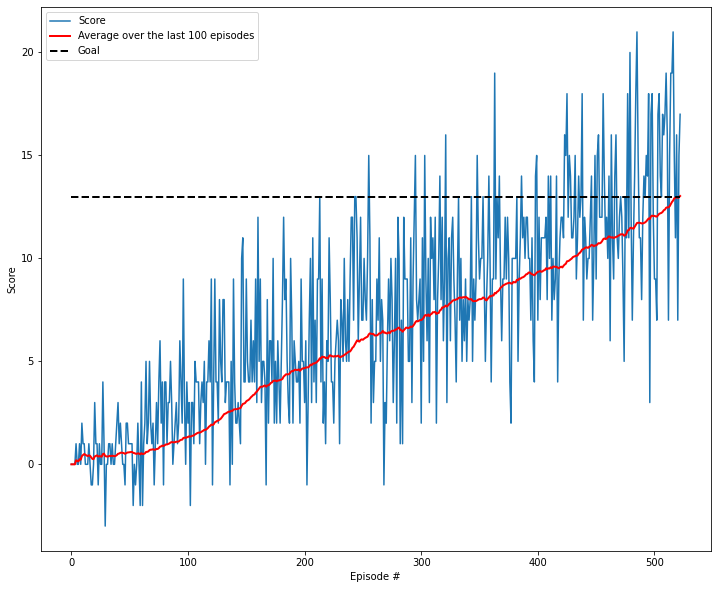

In [6]:
scores, average, goal = training(agent_ddqn)

# plot the scores
fig = plt.figure(figsize=(12, 10))
plt.plot(np.arange(len(scores)), scores, label = 'Score')
plt.plot(average, 'r-', label = 'Average over the last 100 episodes',linewidth = 2)
plt.plot(goal, 'k--',label = 'Goal', linewidth = 2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### Load pretrained weights

In [ ]:
agent_ddqn.primary_network.load_state_dict(torch.load('ddqn_results\weights\checkpoint_final.pth'))

In [ ]:
while True:
    state = env_info.vector_observations[0]
    with torch.no_grad():
        action = agent_ddqn.primary_network(state)
    env_info = env.step(action.astype(int))[brain_name] 
    done = env_info.local_done[0]
    if done:
        break

## Training agent with Double Deep Q Network and Prioritized Experience Replay

In [5]:
from ddqn_per import Agent as Agent_PER
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

agent_per = Agent_PER(state_size=len(state), action_size=brain.vector_action_space_size, seed=0)

Episode 1	Average Score: 0.00
Episode 2	Average Score: 0.50
Episode 3	Average Score: 0.67
Episode 4	Average Score: 1.00
Episode 5	Average Score: 0.80
Episode 6	Average Score: 0.83
Episode 7	Average Score: 1.00
Episode 8	Average Score: 0.88
Episode 9	Average Score: 0.78
Episode 10	Average Score: 0.60
Episode 11	Average Score: 0.55
Episode 12	Average Score: 0.42
Episode 13	Average Score: 0.31
Episode 14	Average Score: 0.14
Episode 15	Average Score: 0.20
Episode 16	Average Score: 0.19
Episode 17	Average Score: 0.18
Episode 18	Average Score: 0.28
Episode 19	Average Score: 0.26
Episode 20	Average Score: 0.25
Episode 21	Average Score: 0.24
Episode 22	Average Score: 0.23
Episode 23	Average Score: 0.26
Episode 24	Average Score: 0.29
Episode 25	Average Score: 0.32
Episode 26	Average Score: 0.35
Episode 27	Average Score: 0.37
Episode 28	Average Score: 0.36
Episode 29	Average Score: 0.45
Episode 30	Average Score: 0.43
Episode 31	Average Score: 0.42
Episode 32	Average Score: 0.34
Episode 33	Averag

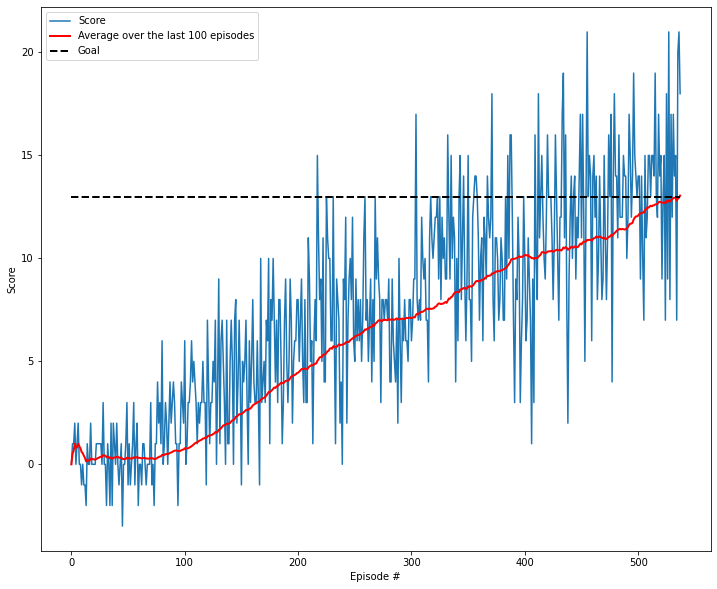

In [6]:
scores, average, goal = training(agent_per)

# plot the scores
fig = plt.figure(figsize=(12, 10))
plt.plot(np.arange(len(scores)), scores, label = 'Score')
plt.plot(average, 'r-', label = 'Average over the last 100 episodes',linewidth = 2)
plt.plot(goal, 'k--',label = 'Goal', linewidth = 2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

### Load pretrained weights

In [ ]:
agent_per.primary_network.load_state_dict(torch.load('per_results\weights\checkpoint_final.pth'))

In [ ]:
while True:
    state = env_info.vector_observations[0]
    with torch.no_grad():
        action = agent_per.primary_network(state)
    env_info = env.step(action.astype(int))[brain_name] 
    done = env_info.local_done[0]
    if done:
        break